In [1]:
import numpy as np
import openpnm as op
import porespy as ps
import matplotlib.pyplot as plt
import pandas as pd
import os
from openpnm.models import physics as mods
from scipy import stats
from skimage.measure import euler_number

np.random.seed(10)
np.set_printoptions(precision=4)
resolution = 2.32e-06
im_shape = 128
snwp = np.arange(0, 1.005, 0.005)


def invasion(phase,direction):
    ip = op.algorithms.InvasionPercolation(network=pn)
    ip.setup(phase=phase)
    in_pores=pn.pores(direction)
    ip.set_inlets(pores=in_pores)
    ip.run()
    return ip
    
def stokes_flow(phase,inlet,outlet):
    st = op.algorithms.StokesFlow(network=pn)
    st.setup(phase=phase)
    # in boundary front water saturation is 1
    # Boundary pores with constant condition
    # left is the inlet of flow
    st.set_value_BC(pores=pn.pores(inlet), values=0)
    # outlet of flow
    st.set_value_BC(pores=pn.pores(outlet), values=1) # this part needs some validation
    st.run()
    return st

def cal_absolute_perm(image_size,resolution,outlet,st):
    A = (image_size*image_size) *resolution**2 # m^2
    L = image_size * resolution # m
    mu = water['pore.viscosity'].max() # N s/m^2 or Pa s
    Pressure = 1 # pa
    delta_P = Pressure - 0

    Q = st.rate(pores=pn.pores(outlet), mode='group')
    K = Q[0] * L * mu / (A * delta_P)

    return K/0.98e-12*1000 # unit md

def cal_eff_perm(image_size,resolution,outlet,st,phase):
    A = (image_size*image_size) *resolution**2
    L = image_size * resolution
    mu = phase['pore.viscosity'].max() # N s/m^2 or Pa s
    Pressure = 1 # pa
    delta_P = Pressure - 0

    Q = st.rate(pores=pn.pores(outlet), mode='group')
    K = Q[0] * L * mu / (A * delta_P)

    return K/0.98e-12*1000

def network_extract(im,resolution):

    snow = ps.networks.snow(
    im=im,
    voxel_size=resolution)

    proj = op.io.PoreSpy.import_data(snow)

    return proj

def get_physics(gen_physics):
    gen_physics.add_model(propname='throat.hydraulic_conductance',
                model=mods.hydraulic_conductance.classic_hagen_poiseuille)
    gen_physics.add_model(propname='throat.entry_pressure',
                model=mods.capillary_pressure.washburn)
    return gen_physics

def load_nparray(fname,name):
    # fname: image index
    # name: rock type
    # PATH: current working directory
    load_PATH = name+'-sub/'+ fname
    im1 = np.load(load_PATH)
    return im1

im = np.load('1.npy')
ws = op.Workspace()
resolution = 2.25e-6 
snow = ps.networks.snow(
im=im,
voxel_size=resolution)

proj = op.io.PoreSpy.import_data(snow)
pn,geo = proj[0],proj[1]

# os.chdir('/akshat/s0/zur74/data')
# os.chdir('/Users/zihanren/OneDrive/tmp')
data_tmp = {}

data_tmp['coordination'] = np.mean(pn.num_neighbors(pn.Ps))
data_tmp['porosity'] = ps.metrics.porosity(im)
data_tmp['pore.diameter'] = np.mean(geo['pore.diameter'])
data_tmp['throat.diameter'] = np.mean(geo['throat.diameter'])
data_tmp['euler'] = euler_number(im,connectivity=3)

health = pn.check_network_health()
op.topotools.trim(network=pn, pores=health['trim_pores'])

if ( (len(pn.pores('top')) > 0) & (len(pn.pores('bottom')) > 0) ):
    inlet = 'top'
    outlet = 'bottom'

elif ( (len(pn.pores('left')) > 0) & (len(pn.pores('right')) > 0) ):
    inlet = 'left'
    outlet = 'right'

elif ( (len(pn.pores('front')) > 0) & (len(pn.pores('back')) > 0) ):
    inlet = 'front'
    outlet = 'back'

# define phase and physics
# assuming temperature is 
air = op.phases.Air(network=pn)
water = op.phases.Water(network=pn)
air['pore.contact_angle'] = 180
water['pore.contact_angle'] = 0
water['pore.surface_tension'] = 0.064
air['pore.surface_tension'] = 0.064

phys_air = op.physics.GenericPhysics(network=pn, phase=air, geometry=geo)
phys_water=op.physics.GenericPhysics(network=pn, phase=water, geometry=geo)
phys_air = get_physics(phys_air)
phys_water = get_physics(phys_water)


------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  249
Peaks after trimming saddle points:  143
Peaks after trimming nearby peaks:  143
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 244/244 [00:01<00:00, 233.05it/s]


# Explanation of invasion percolation
Comparing with ordinary percolation, invasion percolation starts from inlet. Non-wetting phase only invades adjacent pore and throats that are already filled with non-wetting phase. Not all possible throats are filled. Whereas during ordinary percolation, the filling process is strictly controlled by the sequence of throat size. 

Ordinary percolation: Displacement in a porous medium where the pore and throat size vary, but without any long-range spatial correlation.

In [2]:
ip=invasion(air,inlet)
st = stokes_flow(water,inlet,outlet)
Q_abs_water = st.rate(pores=pn.pores(outlet))
kabs_tmp = cal_absolute_perm(im_shape,resolution,outlet,st)
val = 0
phys_water.regenerate_models() 
kw_tmp = []

for s in snwp:  
    air.update(ip.results(Snwp=s))
    phys_water['throat.hydraulic_conductance'][air['throat.occupancy']] = val
    st.run()
    kw_tmp.append(cal_eff_perm(im_shape,resolution,outlet,st,water))
    phys_water.regenerate_models()

phys_water.regenerate_models()
phys_air.regenerate_models()





In [3]:
st_a = stokes_flow(air,inlet,outlet)
Q_abs_air = st_a.rate(pores=pn.pores(outlet))
knw_tmp = []

for s in snwp:  
    air.update(ip.results(Snwp=s))
    phys_air['throat.hydraulic_conductance'][~air['throat.occupancy']] = val
    st_a.run()
    knw_tmp.append(cal_eff_perm(im_shape,resolution,outlet,st_a,air))
    phys_air.regenerate_models()

In [4]:
# calcualte kr
krw_tmp = np.array(kw_tmp)/kabs_tmp
krnw_tmp = np.array(knw_tmp)/kabs_tmp

data_tmp['kr_water'] = krw_tmp
data_tmp['kr_air'] = krnw_tmp
data_tmp['k_water'] = np.array(kw_tmp)
data_tmp['k_air'] = np.array(krnw_tmp)
data_tmp['kabs'] = kabs_tmp
kr_data = pd.DataFrame(snwp,columns=['Snw'])
kr_data['kr_water'] = data_tmp['kr_water']
kr_data['kr_air'] = data_tmp['kr_air']

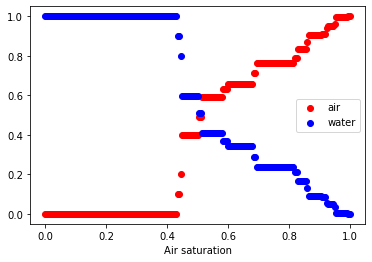

In [8]:
f = plt.figure()
plt.scatter(kr_data['Snw'],kr_data['kr_air'],c='r',label='air')
plt.scatter(kr_data['Snw'],kr_data['kr_water'],c='b',label='water')
plt.xlabel('Air saturation')
plt.legend()

# Caveats:
Prediction of relative permeability fails to considering connate water saturation

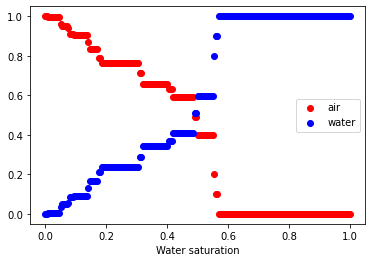

In [7]:
f = plt.figure()
plt.scatter(1-kr_data['Snw'],kr_data['kr_air'],c='r',label='air')
plt.scatter(1-kr_data['Snw'],kr_data['kr_water'],c='b',label='water')
plt.xlabel('Water saturation')
plt.legend()

There is no irreducible water saturation during percolation process. 
The residual gas saturation is 0.4